# CASSINI Hackathons - $5^{th} edition$
## Space for Defence & Security

### Kerberos
![title](./images/mundi/croatia_border-bo1layer.png)


A platform utilizing satellite data to connect with a fleet of drones, while facilitating user and sensor input. Fore detailed information, please visit [TAIKAI page](https://taikai.network/cassinihackathons/hackathons/defence-security/projects/clfce3bgf84242801x2lltfw0ky/idea)

#### MAIN

In [2]:
import pandas as pd
import geopandas as gpd
import folium

from folium import plugins
from typing import Union, Any
from shapely.geometry import Polygon, Point, MultiPolygon

from haversine import haversine, Unit

from IPython.display import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

##### Propositions 

![title](./images/mundi/cro-srb_border-true_color.png)

1. Define polygon including Croatia / Serbia border 
    * The polygon constraints the area of the border that we will be focusing on
2. Constrain the target area defined by the polygon
3. Import the point coordinates of the Croatia border
    * This step will serve to target the focus of our analysis -> the area that drones should cover
4. Draw circles with the radius = \<range\> / 2 
    * The cirles area represent the field that can be covered by one drone according approximately average range and speed
    * Notes: drone should be able to return back or surveilance
5. Next we introduce an Anchor Point
    * Serves for help to identify the closest point on the exterior border of drone operating area which can be used as the place for drone staionary station or drone box
    * The idea is that from this point the drone has the shortest distance to the critical part of the border points 
    + The Anchor point can be adapted for later use for example headquarters of law enforcement forces - the points can be added / removed and the drone network can be optimized accordingly
6. Final representation of drone operative network is proposed

Make function which takes closest border point to the Croatia border and calculates distance

> NOTE! Folium package use the \<latitude, longitude\> format of coordinates

In [3]:
latitude_1: float = 45
longitude_1: float = 19
z: int = 10
location_croatia_south: list = (latitude_1, longitude_1)

# For displaying satelitte images
IMG_MUNDI_WIDTH = 800
IMG_MUNDI_HEIGHT = 400

In [4]:
def swap_xy(geom: Any) -> Any:
    """
    The function swaps coordinates of shapely objects. 
    Source: https://gis.stackexchange.com/questions/291247/interchange-y-x-to-x-y-with-geopandas-python-or-qgis
    """
    if geom.is_empty:
        return geom

    if geom.has_z:
        def swap_xy_coords(coords):
            for x, y, z in coords:
                yield (y, x, z)
    else:
        def swap_xy_coords(coords):
            for x, y in coords:
                yield (y, x)

    # Process coordinates from each supported geometry type
    if geom.type in ('Point', 'LineString', 'LinearRing'):
        return type(geom)(list(swap_xy_coords(geom.coords)))
    elif geom.type == 'Polygon':
        ring = geom.exterior
        shell = type(ring)(list(swap_xy_coords(ring.coords)))
        holes = list(geom.interiors)
        for pos, ring in enumerate(holes):
            holes[pos] = type(ring)(list(swap_xy_coords(ring.coords)))
        return type(geom)(shell, holes)
    elif geom.type.startswith('Multi') or geom.type == 'GeometryCollection':
        # Recursive call
        return type(geom)([swap_xy(part) for part in geom.geoms])
    else:
        raise ValueError('Type %r not recognized' % geom.type)

def make_border_area(obj: list[tuple], inter_area: Polygon) -> list:
    """
    Function helps to identify the area on the border that we focus on. 
    """
    res: list = []
    for i, p in enumerate(obj):
        if Point(p).intersects(inter_area):
            res.append(p)
    return res

def draw_folium(**kwargs) -> folium.Map:
    """
    Function pre-draw and create folium.Map object that can be adjusted or displayed.
    """
    z = kwargs.get('z', 9)
    add_points_fl: bool = kwargs.get('add_points_fl', True)
    points: pd.DataFrame = pd.read_csv('./coordinates.csv')

    fol_map: folium.Map = folium.Map(location=location_croatia_south, tiles='OpenStreetMap', zoom_start=z)
    
    if add_points_fl:
        for i, r in points.iterrows():
            folium.Marker([r['latitude'], r['longitude']], radius=5, color='red').add_to(fol_map) # , tooltip='click me'

    return fol_map

def coord_lister(geom):
    """
    Function extracts and returns coordinates of the polygon geoseries python objects.
    Source: https://gis.stackexchange.com/questions/300747/how-to-convert-geoseries-polygons-to-lists-of-coordinates
    """
    coords = list(geom.exterior.coords)
    return (coords)

def calc_point_distance_geopandas(point_a, point_b):
    """
    Function calculates cartesian distance between 2 points using GeoSeries object.
    """
    return float(gpd.GeoSeries(Point(point_a)).distance(gpd.GeoSeries(Point(point_b)))[0])

def calc_point_distance_hav(point_a, point_b, unit: Unit = Unit.METERS) -> float:
    """
    Function calculates haversine distance between two point coordinates in format <latitude, longitute>.
    """
    return haversine(point1=point_a, point2=point_b, unit=unit)

def find_closest_point(poly: Union[Polygon, list], point: Union[Point, list], **kwargs) -> list:
    """
    Function iterates over the exterior border of the shapely polygon object and finds the closest coordinates to the point specified as parameter.
    Params

        :poly [Polygon, list] - polygon object or list of coordinates represented polygon
        :point [Point, list] - point object or list of point objects

    Return

        Polygon object represents a circle.
    """ 
    from copy import deepcopy
    if isinstance(poly, Polygon):
        poly_coords: list = poly.exterior.coords[:-1]
    elif isinstance(poly, list):
        poly_coords: list = deepcopy(poly)
    else:
        raise NotImplementedError(f'Unrecognized type of `poly` parameter: {type(poly)}')
    
    closest_point = poly_coords.pop(0)
    min_dist = 10e5
    for x in poly_coords:
        dist = calc_point_distance_hav(x, point, **kwargs)
        if dist < min_dist:
            closest_point = deepcopy(x)
            min_dist = deepcopy(dist)
    
    return closest_point


In [5]:
def create_circle_with_radius(lon: float, lat: float, radius: float) -> Polygon:
    """
    Function creates polygon object which represents the circle with radius around the centroid coordinates specified as parameters.
    Adaptade using: https://gis.stackexchange.com/questions/121256/creating-a-circle-with-radius-in-metres
    Params

        :lon [float] - longitude coordinates of the point that we want to create circle around
        :lat [float] - latitude coordinates of the point that we want to create circle around
        :radius [float] - radius [in meters] of the circle that we want to draw around the coordinates

    Return

        Polygon object represents a circle.
    """
    from functools import partial

    import pyproj
    from shapely import geometry
    from shapely.geometry import Point, Polygon
    from shapely.ops import transform

    # lon, lat = -122.431297, 37.773972 # lon lat for San Francisco
    # lon, lat = test_point[0], test_point[1]
    # radius = 1000  # in m

    local_azimuthal_projection = "+proj=aeqd +R=6371000 +units=m +lat_0={} +lon_0={}".format(
        lat, lon
    )
    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
        pyproj.Proj(local_azimuthal_projection),
    )
    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    )

    center = Point(float(lon), float(lat))
    point_transformed = transform(wgs84_to_aeqd, center)
    buffer = point_transformed.buffer(radius)
    # Get the polygon with lat lon coordinates
    circle_poly = transform(aeqd_to_wgs84, buffer)
    return circle_poly

1. Define polygon including Croatia / Serbia border 
    * The polygon constraints the area of the border that we will be focusing on
2. Constrain the target area defined by the polygon

In [6]:
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd 
import folium
import shapely as shp

croatia_border_geojson_path: str = './croatia-detailed-boundary_891.geojson'
croatia_border = gpd.read_file(croatia_border_geojson_path)

croatia_multipoly: MultiPolygon = croatia_border.geometry[0]

croatia_multipoly_lat_lng = swap_xy(croatia_multipoly)

lat_max: float = 45.769439
lat_min: float = 44.742832
lng_max: float = 19.613342
lng_min: float = 18.511963
target_area: Polygon = Polygon(((lat_min, lng_min), (lat_max, lng_min), (lat_max, lng_max), (lat_min, lng_max)))

croatia_border_area: list = []  
croatia_border_target_points: list = []

for i, g in enumerate(croatia_multipoly_lat_lng.geoms):
    
    if g.intersects(target_area):
        print(f"{i} geom in")
        croatia_border_area.append(g)
        croatia_border_target_points.extend(list(g.exterior.coords)[:-1])



0 geom in


In [7]:
croatia_border_target_points = make_border_area(croatia_border_target_points, target_area)
croatia_border_target_polygon: Polygon = Polygon(croatia_border_target_points)

In [8]:
croa_south = draw_folium()
folium.Polygon(locations=list(croatia_border_target_polygon.exterior.coords)[:-1], color='red', size=5).add_to(croa_south)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south


3. Import the point coordinates of the Croatia border
    * This step will serve to target the focus of our analysis -> the area that drones should cover

In [9]:
croa_south = draw_folium()

fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(croatia_border_target_points):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='red', radius=5))

croa_south.add_child(fg)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south


4. Draw circles with the radius = \<range\> / 2 
    * The cirles area represent the field that can be covered by one drone according approximately average range and speed
    * Notes: drone should be able to return back or surveilance

In [10]:
croatia_border_target_points[0]

(45.764908, 18.900169)

In [11]:
area_for_action_list: list = []
#!!
radius_area: float = 1000.0

for i, p in enumerate(croatia_border_target_points):
    #! croatia_border_target_points are in <latitude, longitude> format
    temp_circle = create_circle_with_radius(p[0], p[1], radius_area)
    area_for_action_list.append(temp_circle)

In [12]:
croa_south = draw_folium()

fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(croatia_border_target_points):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='red', radius=5))
    fg.add_child(folium.Polygon(locations=area_for_action_list[i].exterior.coords[:-1], size=5, color='black'))

croa_south.add_child(fg)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south

In this section we will optimize the drone network according the simple rules:

* since some of the points are close to each other and the area is dense. Therefore we can skip some of the closest edges of the drone network and create more sparse representation but still enabling the drones to cover most of the area
* iterates over the circles (now -> they are representing 1km radius around the target border coordinates)
* if the circle intersects with their nearest counterparts (before and ahead of the current edge) we skip this are since the two drone network edges mostly cover the current area as well* 

In [13]:
area_for_action_list_trim: list = []
skiped: bool = False 

for i in range(len(area_for_action_list)):
    if i < 2:
        area_for_action_list_trim.append(area_for_action_list[i])
        continue
    
    if skiped:
        skiped = False
        area_for_action_list_trim.append(area_for_action_list[i])
        continue

    if area_for_action_list[i].intersects(area_for_action_list[i-1]) and \
        area_for_action_list[i].intersects(area_for_action_list[i+1]):
        skiped = True
        continue
    
    
    area_for_action_list_trim.append(area_for_action_list[i])

print(f"# of edges in full network: {len(area_for_action_list)}")
print(f"# of edges in optimized network: {len(area_for_action_list_trim)}")

# of edges in full network: 162
# of edges in optimized network: 118


In [14]:
croa_south = draw_folium(add_points_fl=False)

fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(croatia_border_target_points):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='red', radius=5))

for i, g in enumerate(area_for_action_list_trim):
    fg.add_child(folium.Polygon(locations=g.exterior.coords[:-1], size=5, color='black'))

croa_south.add_child(fg)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south

5. Next we introduce an Anchor Point
    * Serves for help to identify the closest point on the exterior border of drone operating area which can be used as the place for drone staionary station or drone box
    * The idea is that from this point the drone has the shortest distance to the critical part of the border points 
    + The Anchor point can be adapted for later use for example headquarters of law enforcement forces - the points can be added / removed and the drone network can be optimized accordingly

In [15]:
geo_anchor_point = gpd.GeoSeries(croatia_border_target_polygon).centroid
shp_anchor_point: Point = geo_anchor_point.geometry[0]
anchor_point: list = list(*shp_anchor_point.coords)

In [16]:
croa_south = draw_folium(add_points_fl=False)

fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(croatia_border_target_points):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='red', radius=5))

for i, g in enumerate(area_for_action_list_trim):
    fg.add_child(folium.Polygon(locations=g.exterior.coords[:-1], size=5, color='black'))

fg.add_child(folium.Marker(location=anchor_point, icon=folium.Icon(prefix='fa', icon='drone')))

croa_south.add_child(fg)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south

In [17]:
closest_points_to_anchor: list = []

for i, g in enumerate(area_for_action_list_trim):
    p = find_closest_point(g, anchor_point)
    closest_points_to_anchor.append(p)

In [18]:
croa_south = draw_folium(add_points_fl=False)

fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(croatia_border_target_points):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='red', radius=5))

for i, g in enumerate(area_for_action_list_trim):
    fg.add_child(folium.Polygon(locations=g.exterior.coords[:-1], size=5, color='black'))

for i, g in enumerate(closest_points_to_anchor):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='blue', radius=5))

fg.add_child(folium.Marker(location=anchor_point, icon=folium.Icon(prefix='fa', icon='drone')))

croa_south.add_child(fg)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south

Draw circle area with centroids that reflect the drone box 

In [19]:
drone_box_areas: list = []
#!!
# radius_area: float = 1000.0

for i, p in enumerate(closest_points_to_anchor):
    #! croatia_border_target_points are in <latitude, longitude> format
    temp_circle = create_circle_with_radius(p[0], p[1], radius_area)
    drone_box_areas.append(temp_circle)

In [20]:
croa_south = draw_folium(add_points_fl=False)

fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(croatia_border_target_points):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='red', radius=5))

for i, g in enumerate(drone_box_areas):
    fg.add_child(folium.Polygon(locations=g.exterior.coords[:-1], size=5, opacity=0.5, color='black'))

for i, g in enumerate(closest_points_to_anchor):
    fg.add_child(folium.Circle(location=[g[0], g[1]], color='blue', radius=5))

fg.add_child(folium.Marker(location=anchor_point, icon=folium.Icon(prefix='fa', icon='drone')))

croa_south.add_child(fg)
folium.Polygon(locations=list(target_area.exterior.coords), color='blue', size=5).add_to(croa_south)
croa_south

In [21]:
print(type(croatia_border))
print(croatia_border.crs)
croatia_border.to_crs(epsg=4326)
print(croatia_border.crs)


<class 'geopandas.geodataframe.GeoDataFrame'>
EPSG:4326
EPSG:4326


In [22]:
croatia_border_target_points[0]

(45.764908, 18.900169)

In [23]:
# Avg speed of the drone is ~ 50 mph - which is in ideal condition (not windy, top battery, ...) ~ 22m/s - we round to 20m/s
# https://www.remoteflyer.com/how-fast-can-a-drone-fly-with-examples/
drone_speed_avg = 20 # mps
distances_to_border_points: list = []
times_to_come: list = []
for i, border_point in enumerate(croatia_border_target_points):
    closest_drone_point = find_closest_point(closest_points_to_anchor, border_point)
    distance_to_border_point = calc_point_distance_hav(closest_drone_point, border_point)
    distances_to_border_points.append(distance_to_border_point)

    temp_time = distance_to_border_point / drone_speed_avg
    times_to_come.append(temp_time)

    

In [24]:
drone_dat: pd.DataFrame = pd.DataFrame({'Distance': distances_to_border_points, 'Time to close': times_to_come})

In [25]:
drone_dat.mean()

Distance         868.211161
Time to close     43.410558
dtype: float64

#### Image assets 

6. Final representation of drone operative network is proposed


In [26]:
croa_south = draw_folium(add_points_fl=False)
drone_icon = 'satellite' # 'plug'
fg = folium.FeatureGroup(name='border points')

for i, g in enumerate(drone_box_areas):
    fg.add_child(folium.Polygon(locations=g.exterior.coords[:-1], size=5, opacity=0.5, color='black'))

for i, g in enumerate(closest_points_to_anchor):
    fg.add_child(folium.Marker(location=[g[0], g[1]], color='red', size=0.5, icon=folium.Icon(color='red', prefix='fa', icon=drone_icon, angle=45)))


fg.add_child(folium.Marker(location=anchor_point, icon=folium.Icon(icon='home', prefix='fa')))

croa_south.add_child(fg)
croa_south

Sattelite images acquired from the [mundi serivce](https://mundiwebservices.com) ([Sentinel-2 L2A](https://mundiwebservices.com/data/sentinel-2))

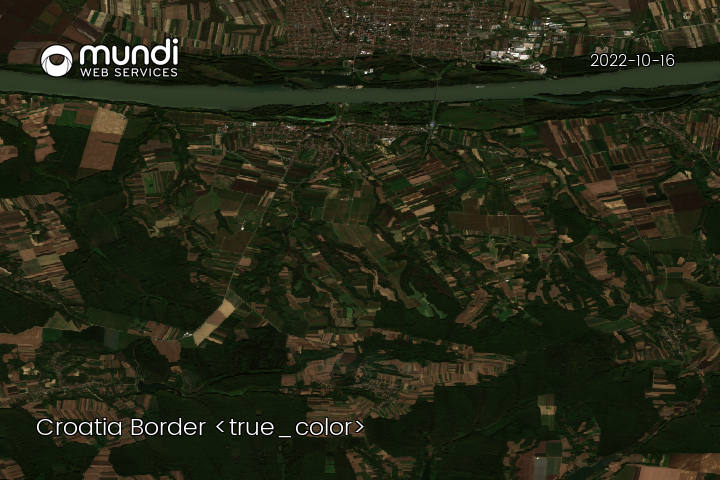

In [27]:
Image("./images/mundi/croatia_border-true_color-zoom3.png", width=IMG_MUNDI_WIDTH, height=IMG_MUNDI_HEIGHT)

In [28]:
IMG_MUNDI_WIDTH=800; IMG_MUNDI_HEIGHT=400

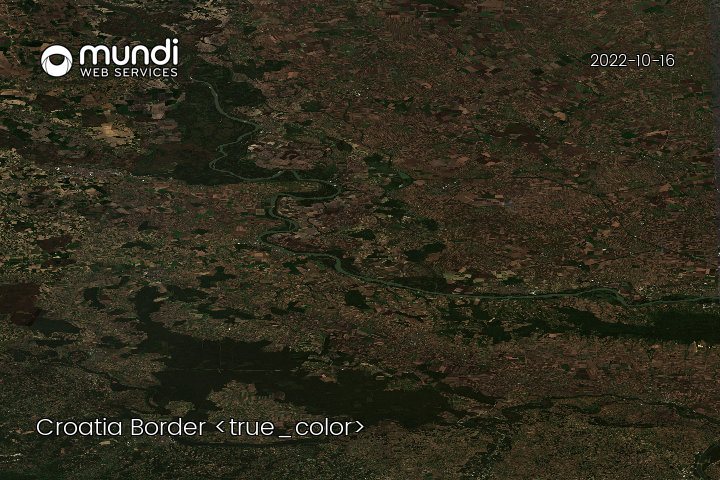

In [29]:
Image("./images/mundi/croatia_border-true_color.png", width=IMG_MUNDI_WIDTH, height=IMG_MUNDI_HEIGHT)

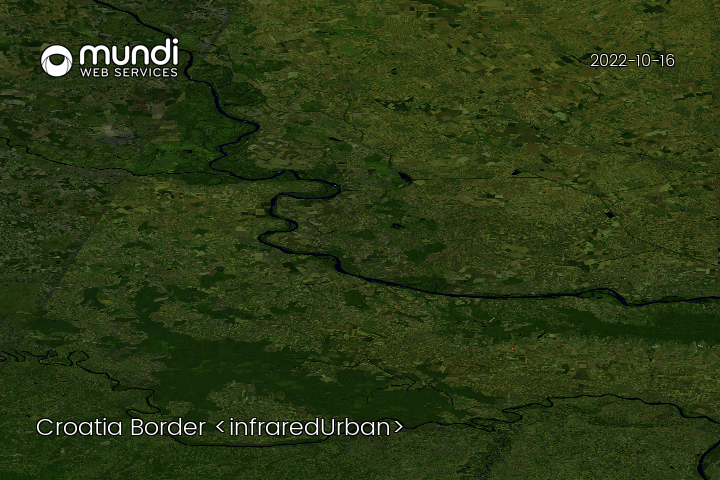

In [30]:
Image("./images/mundi/croatia_border-color_infrared_urban.png", width=IMG_MUNDI_WIDTH, height=IMG_MUNDI_HEIGHT)

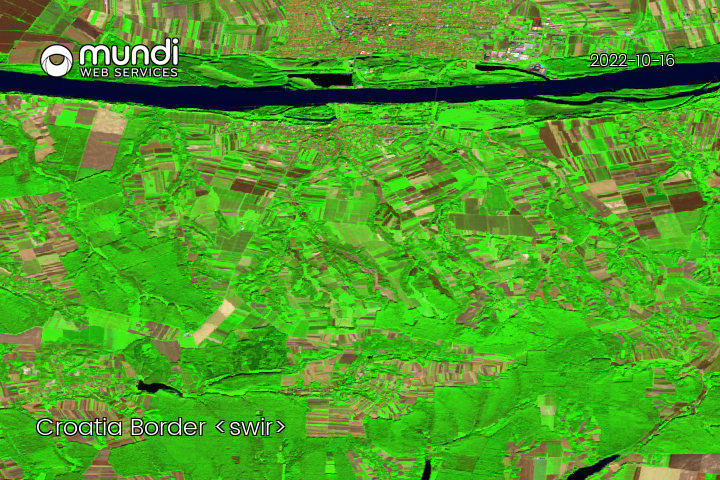

In [31]:
Image("./images/mundi/croatia_border-swir-zoom3.png", width=IMG_MUNDI_WIDTH, height=IMG_MUNDI_HEIGHT)

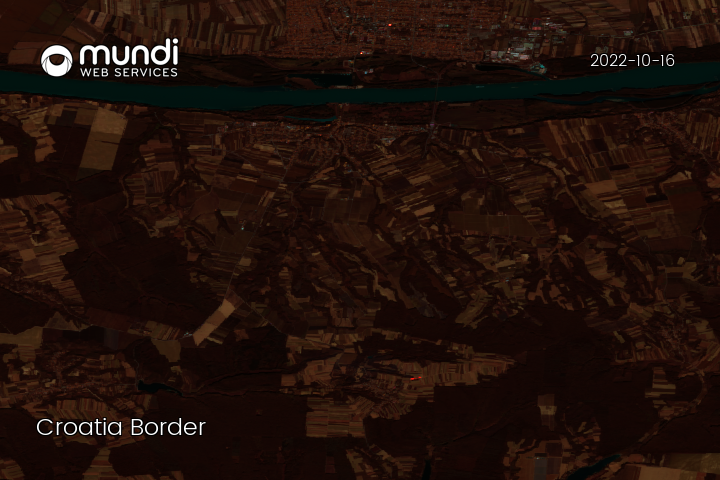

In [32]:
Image("./images/mundi/croatia_border-geology-zoom3.png", width=IMG_MUNDI_WIDTH, height=IMG_MUNDI_HEIGHT)

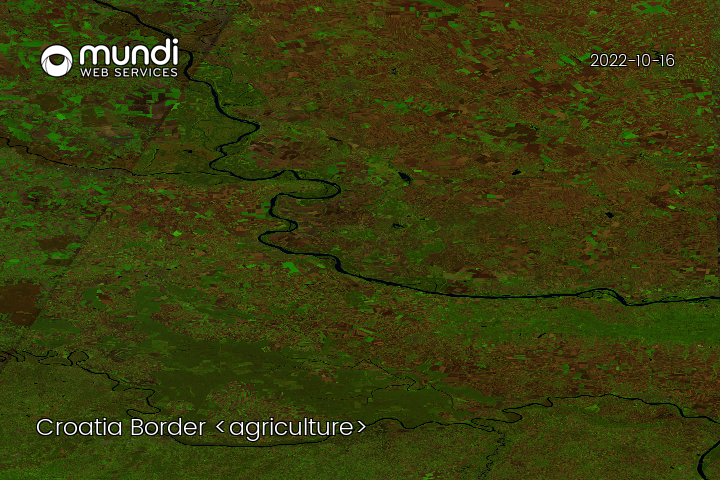

In [33]:
Image("./images/mundi/croatia_border-agriculture.png", width=IMG_MUNDI_WIDTH, height=IMG_MUNDI_HEIGHT)

##### Appendix

In [34]:
print(pd.read_csv('./Dronebox Comparison - Sheet1.csv'))

      Company                  Product Flight Time (up to)      Charging time  \
0    Skysense           Skysense SIS-D              45 min             45 min   
1    Percepto             Percepto AIM              35 min             80 min   
2  DroneVolt       The DroneVolt DvS-3              30 min             60 min   
3    FlytBase                   SkyBox              50 min             90 min   
4    Fortress  Fortress UAV Wind Guard   180 min (3 hours)  300 min (5 hours)   

  Range (up to)     Cost    Type  \
0          7 km  50,000$  Rotary   
1          1 km  50,000$  Rotary   
2          5 km  35,000$  Rotary   
3          2 km  20,000$  Rotary   
4         50 km  30,000$    Wind   

                                         Application  
0          Inspections, surveillance, and monitoring  
1            Inspections, surveillance, and security  
2                Inspections, mapping, and surveying  
3             Inspections, surveillance, and mapping  
4  Inspections, surve